In [1]:
import os
from tqdm import tqdm
from src.utils import *
from src.params import *
from src.models import FCN
from ranger import Ranger20
import matplotlib.pyplot as plt
from src.dataset import RapidEye
from torch.nn import CrossEntropyLoss
from sklearn.metrics import jaccard_score
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, random_split
from albumentations import Compose, HorizontalFlip, VerticalFlip, RandomCrop, CenterCrop, Normalize

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
normalize = Normalize(mean=train_mean_rgb, std=train_std_rgb)

train_transforms = Compose([
    HorizontalFlip(p=0.5),
    VerticalFlip(p=0.5),
    RandomCrop(height=128, width=128, p=1),
    normalize,
    ToTensorV2()
])

test_transforms = Compose([
    CenterCrop(height=128, width=128, p=1),
    normalize,
    ToTensorV2()
])

In [4]:
train_dataset = RapidEye(
    band="RGB",
    img_dir=train_path,
    mask_dir=mask_path,
    transform=train_transforms
)
train_dataset, val_dataset = random_split(
    train_dataset,
    lengths=[int(len(train_dataset) * 0.8), len(train_dataset) - int(len(train_dataset) * 0.8)]
)
test_dataset = RapidEye(
    band="RGB",
    mask_dir=None,
    img_dir=test_path,
    transform=test_transforms
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
)
val_loader = DataLoader(
    batch_size=BATCH_SIZE,
    dataset=val_dataset,
    pin_memory=True,
    num_workers=0,
    shuffle=True,
)
test_loader = DataLoader(
    batch_size=BATCH_SIZE,
    dataset=test_dataset,
    pin_memory=True,
    num_workers=0,
)

In [5]:
fcn = FCN(n_classes=3, n_bands=3, pretrained=True)
fcn = fcn.to(device)
criterion = CrossEntropyLoss()
optimizer = Ranger20(fcn.parameters())

records = { "train_loss": [], "val_loss": [], "val_iou": [], "val_acc": [] }

Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


In [6]:
for epoch in range(EPOCH):
    fcn.train()

    train_loss = 0
    for i, data in tqdm(enumerate(train_loader)):
        x, mask = data
        x = x.to(device)
        mask = mask.to(device)
        y_pred = fcn(x)
        y_pred = y_pred["out"]

        loss = criterion(y_pred, mask)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 10 == 0:
            print(f"Iteration {i} / Epoch {epoch}: Training Loss {loss}")
    train_loss /= len(train_loader)
    records["train_loss"].append(train_loss.item())

    with torch.no_grad():
        fcn.eval()
        val_iou = 0
        val_acc = 0
        val_loss = 0

        for i, data in tqdm(enumerate(val_loader)):
            x, mask = data
            x = x.to(device)
            mask = mask.to(device)
            y_pred = fcn(x)
            y_pred = y_pred["out"]

            loss = criterion(y_pred, mask)
            val_loss += loss

            y_pred = y_pred.argmax(axis=1)
            val_acc += torch.eq(y_pred, mask).float().mean()
            val_iou += jaccard_score(y_pred.reshape(-1).cpu(), mask.reshape(-1).cpu(), average="weighted")

    val_acc /= len(val_loader)
    val_iou /= len(val_loader)
    val_loss /= len(val_loader)

    records["val_acc"].append(val_acc.item())
    records["val_iou"].append(val_iou.item())
    records["val_loss"].append(val_loss.item())

    print(f"Epoch {epoch}: Validation Loss {val_loss} | Validation Pixel-wise Accuracy: {val_acc} | Validation IoU: {val_iou}")

10it [00:08,  1.21it/s]

Iteration 9 / Epoch 0: Training Loss 1.122360110282898


20it [00:16,  1.29it/s]

Iteration 19 / Epoch 0: Training Loss 1.0940889120101929


23it [00:17,  1.30it/s]
6it [00:05,  1.13it/s]
0it [00:00, ?it/s]

Epoch 0: Validation Loss 1.0402774810791016 | Validation Pixel-wise Accuracy: 0.40951234102249146 | Validation IoU: 0.2753391767535498


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 1: Training Loss 1.0806385278701782


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 1: Training Loss 0.9495545029640198


23it [00:10,  2.10it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 1: Validation Loss 1.0603060722351074 | Validation Pixel-wise Accuracy: 0.40800678730010986 | Validation IoU: 0.26532441764026626


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 2: Training Loss 0.9775913953781128


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 2: Training Loss 0.9126628637313843


23it [00:10,  2.11it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 2: Validation Loss 0.9759681224822998 | Validation Pixel-wise Accuracy: 0.5530364513397217 | Validation IoU: 0.38312020878894426


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 3: Training Loss 0.9555941820144653


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 3: Training Loss 0.8900665044784546


23it [00:10,  2.11it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 3: Validation Loss 0.921606719493866 | Validation Pixel-wise Accuracy: 0.575846791267395 | Validation IoU: 0.406561556453481


10it [00:04,  1.94it/s]

Iteration 9 / Epoch 4: Training Loss 0.9113590717315674


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 4: Training Loss 0.9532290697097778


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 4: Validation Loss 0.8915418982505798 | Validation Pixel-wise Accuracy: 0.5945094227790833 | Validation IoU: 0.42463043554696567


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 5: Training Loss 0.8357285857200623


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 5: Training Loss 0.8639625310897827


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 5: Validation Loss 0.8718185424804688 | Validation Pixel-wise Accuracy: 0.5988963842391968 | Validation IoU: 0.42858307204731155


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 6: Training Loss 0.8719596266746521


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 6: Training Loss 0.8540446162223816


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 6: Validation Loss 0.8542478084564209 | Validation Pixel-wise Accuracy: 0.6156618595123291 | Validation IoU: 0.4522371350606002


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 7: Training Loss 0.8013904690742493


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 7: Training Loss 0.7217309474945068


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 7: Validation Loss 0.8475742340087891 | Validation Pixel-wise Accuracy: 0.6120796203613281 | Validation IoU: 0.45072827817930977


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 8: Training Loss 0.7819766998291016


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 8: Training Loss 0.6967270374298096


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 8: Validation Loss 0.8231467604637146 | Validation Pixel-wise Accuracy: 0.6341375112533569 | Validation IoU: 0.4815830084636871


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 9: Training Loss 0.8483774065971375


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 9: Training Loss 0.7958569526672363


23it [00:10,  2.12it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 9: Validation Loss 0.8210029602050781 | Validation Pixel-wise Accuracy: 0.6358461380004883 | Validation IoU: 0.48032599025808437


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 10: Training Loss 0.834723174571991


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 10: Training Loss 0.7601131796836853


23it [00:10,  2.10it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 10: Validation Loss 0.8140362501144409 | Validation Pixel-wise Accuracy: 0.6433649659156799 | Validation IoU: 0.48678737123968835


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 11: Training Loss 0.7411594390869141


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 11: Training Loss 0.881508469581604


23it [00:10,  2.11it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 11: Validation Loss 0.8066879510879517 | Validation Pixel-wise Accuracy: 0.6353326439857483 | Validation IoU: 0.47257522175706673


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 12: Training Loss 0.8028903603553772


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 12: Training Loss 0.7834157347679138


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 12: Validation Loss 0.7929812669754028 | Validation Pixel-wise Accuracy: 0.6565835475921631 | Validation IoU: 0.49761183275336823


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 13: Training Loss 0.6802089810371399


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 13: Training Loss 0.7102818489074707


23it [00:10,  2.13it/s]
6it [00:03,  1.55it/s]
0it [00:00, ?it/s]

Epoch 13: Validation Loss 0.8049044013023376 | Validation Pixel-wise Accuracy: 0.6510452032089233 | Validation IoU: 0.4880161036592912


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 14: Training Loss 0.8258582949638367


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 14: Training Loss 0.8035861849784851


23it [00:10,  2.11it/s]
6it [00:03,  1.50it/s]
0it [00:00, ?it/s]

Epoch 14: Validation Loss 0.767420768737793 | Validation Pixel-wise Accuracy: 0.6620504260063171 | Validation IoU: 0.5078442985754924


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 15: Training Loss 0.727843701839447


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 15: Training Loss 0.8545354604721069


23it [00:10,  2.11it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 15: Validation Loss 0.7907381057739258 | Validation Pixel-wise Accuracy: 0.6575093865394592 | Validation IoU: 0.4988376801906525


10it [00:04,  1.89it/s]

Iteration 9 / Epoch 16: Training Loss 0.8334619998931885


20it [00:09,  1.88it/s]

Iteration 19 / Epoch 16: Training Loss 0.8305914402008057


23it [00:11,  2.08it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 16: Validation Loss 0.7609102129936218 | Validation Pixel-wise Accuracy: 0.6685106158256531 | Validation IoU: 0.511247559802004


10it [00:04,  1.89it/s]

Iteration 9 / Epoch 17: Training Loss 0.7490097880363464


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 17: Training Loss 0.6724960207939148


23it [00:11,  2.07it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 17: Validation Loss 0.7604268789291382 | Validation Pixel-wise Accuracy: 0.662035346031189 | Validation IoU: 0.5029114871482893


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 18: Training Loss 0.6784067153930664


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 18: Training Loss 0.7219187617301941


23it [00:10,  2.10it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 18: Validation Loss 0.7980685234069824 | Validation Pixel-wise Accuracy: 0.6494799256324768 | Validation IoU: 0.4907214230236536


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 19: Training Loss 0.7052422761917114


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 19: Training Loss 0.7508590221405029


23it [00:10,  2.10it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 19: Validation Loss 0.845072865486145 | Validation Pixel-wise Accuracy: 0.6434273719787598 | Validation IoU: 0.48561777932995104


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 20: Training Loss 0.7878235578536987


20it [00:09,  1.87it/s]

Iteration 19 / Epoch 20: Training Loss 0.723475992679596


23it [00:11,  2.08it/s]
6it [00:04,  1.49it/s]
0it [00:00, ?it/s]

Epoch 20: Validation Loss 0.7944526076316833 | Validation Pixel-wise Accuracy: 0.6531897187232971 | Validation IoU: 0.49978095248502025


10it [00:04,  1.89it/s]

Iteration 9 / Epoch 21: Training Loss 0.6661727428436279


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 21: Training Loss 0.6620745062828064


23it [00:10,  2.10it/s]
6it [00:03,  1.50it/s]
0it [00:00, ?it/s]

Epoch 21: Validation Loss 0.802756667137146 | Validation Pixel-wise Accuracy: 0.6531925797462463 | Validation IoU: 0.49722608590471573


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 22: Training Loss 0.6891385316848755


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 22: Training Loss 0.8345457911491394


23it [00:10,  2.09it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 22: Validation Loss 0.8138688802719116 | Validation Pixel-wise Accuracy: 0.6400780081748962 | Validation IoU: 0.4826430863986519


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 23: Training Loss 0.7659408450126648


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 23: Training Loss 0.8120725154876709


23it [00:11,  2.09it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 23: Validation Loss 0.7988387942314148 | Validation Pixel-wise Accuracy: 0.6416373252868652 | Validation IoU: 0.4784134950315859


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 24: Training Loss 0.7905701398849487


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 24: Training Loss 0.8637858629226685


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 24: Validation Loss 0.7332078814506531 | Validation Pixel-wise Accuracy: 0.6837050914764404 | Validation IoU: 0.5317875555986616


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 25: Training Loss 0.6410403847694397


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 25: Training Loss 0.8195773959159851


23it [00:10,  2.13it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 25: Validation Loss 0.7525560855865479 | Validation Pixel-wise Accuracy: 0.6691972017288208 | Validation IoU: 0.5108738254045554


10it [00:04,  1.94it/s]

Iteration 9 / Epoch 26: Training Loss 0.7666380405426025


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 26: Training Loss 0.6902703046798706


23it [00:10,  2.12it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 26: Validation Loss 0.7550132274627686 | Validation Pixel-wise Accuracy: 0.6656548380851746 | Validation IoU: 0.5079896600026286


10it [00:04,  1.94it/s]

Iteration 9 / Epoch 27: Training Loss 0.7723909020423889


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 27: Training Loss 0.7143881916999817


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 27: Validation Loss 0.8129370212554932 | Validation Pixel-wise Accuracy: 0.6590895652770996 | Validation IoU: 0.504275320015747


10it [00:04,  1.89it/s]

Iteration 9 / Epoch 28: Training Loss 0.8339579105377197


20it [00:09,  1.88it/s]

Iteration 19 / Epoch 28: Training Loss 0.7044544816017151


23it [00:11,  2.09it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 28: Validation Loss 0.7891610860824585 | Validation Pixel-wise Accuracy: 0.6508610248565674 | Validation IoU: 0.49710862330780675


10it [00:04,  1.89it/s]

Iteration 9 / Epoch 29: Training Loss 0.6599888801574707


20it [00:09,  1.87it/s]

Iteration 19 / Epoch 29: Training Loss 0.8040664792060852


23it [00:11,  2.07it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 29: Validation Loss 0.7881426811218262 | Validation Pixel-wise Accuracy: 0.6568544507026672 | Validation IoU: 0.496631274872888


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 30: Training Loss 0.7093080282211304


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 30: Training Loss 0.762550950050354


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 30: Validation Loss 0.7949830293655396 | Validation Pixel-wise Accuracy: 0.6593359112739563 | Validation IoU: 0.4986703668432105


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 31: Training Loss 0.7619139552116394


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 31: Training Loss 0.7639068365097046


23it [00:10,  2.11it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 31: Validation Loss 0.7520458102226257 | Validation Pixel-wise Accuracy: 0.6722699999809265 | Validation IoU: 0.5143906123672767


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 32: Training Loss 0.8166444301605225


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 32: Training Loss 0.6963605284690857


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 32: Validation Loss 0.750727653503418 | Validation Pixel-wise Accuracy: 0.6657205820083618 | Validation IoU: 0.5070923830776853


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 33: Training Loss 0.7288125157356262


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 33: Training Loss 0.722689151763916


23it [00:10,  2.12it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 33: Validation Loss 0.8238567113876343 | Validation Pixel-wise Accuracy: 0.6581593155860901 | Validation IoU: 0.5031800038943753


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 34: Training Loss 0.8224070072174072


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 34: Training Loss 0.843285083770752


23it [00:10,  2.11it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 34: Validation Loss 0.7493512630462646 | Validation Pixel-wise Accuracy: 0.6743388175964355 | Validation IoU: 0.517979270735743


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 35: Training Loss 0.7059224247932434


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 35: Training Loss 0.7155407667160034


23it [00:10,  2.11it/s]
6it [00:03,  1.55it/s]
0it [00:00, ?it/s]

Epoch 35: Validation Loss 0.741858959197998 | Validation Pixel-wise Accuracy: 0.6773826479911804 | Validation IoU: 0.5251720368104322


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 36: Training Loss 0.745022177696228


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 36: Training Loss 0.7274103760719299


23it [00:10,  2.12it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 36: Validation Loss 0.7938046455383301 | Validation Pixel-wise Accuracy: 0.6596279144287109 | Validation IoU: 0.5061120010364818


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 37: Training Loss 0.7696623802185059


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 37: Training Loss 0.8035497665405273


23it [00:10,  2.12it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 37: Validation Loss 0.7424105405807495 | Validation Pixel-wise Accuracy: 0.6806563138961792 | Validation IoU: 0.5306144509122394


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 38: Training Loss 0.7604928016662598


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 38: Training Loss 0.8159879446029663


23it [00:10,  2.11it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 38: Validation Loss 0.9230105876922607 | Validation Pixel-wise Accuracy: 0.6147112846374512 | Validation IoU: 0.46820311358596917


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 39: Training Loss 0.7698939442634583


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 39: Training Loss 0.8058575987815857


23it [00:10,  2.12it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 39: Validation Loss 0.7732843160629272 | Validation Pixel-wise Accuracy: 0.6665384769439697 | Validation IoU: 0.5115127762233077


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 40: Training Loss 0.7184959053993225


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 40: Training Loss 0.7600139379501343


23it [00:10,  2.10it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 40: Validation Loss 0.7737250328063965 | Validation Pixel-wise Accuracy: 0.6554613709449768 | Validation IoU: 0.4958259706309211


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 41: Training Loss 0.7926326990127563


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 41: Training Loss 0.6978842616081238


23it [00:10,  2.11it/s]
6it [00:03,  1.55it/s]
0it [00:00, ?it/s]

Epoch 41: Validation Loss 0.760055661201477 | Validation Pixel-wise Accuracy: 0.6692447662353516 | Validation IoU: 0.5178911983406954


10it [00:04,  1.89it/s]

Iteration 9 / Epoch 42: Training Loss 0.7302316427230835


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 42: Training Loss 0.7526960372924805


23it [00:10,  2.11it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 42: Validation Loss 0.7777974009513855 | Validation Pixel-wise Accuracy: 0.6622694730758667 | Validation IoU: 0.5054986859068685


10it [00:04,  1.91it/s]

Iteration 9 / Epoch 43: Training Loss 0.7279443740844727


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 43: Training Loss 0.7323421239852905


23it [00:10,  2.10it/s]
6it [00:03,  1.51it/s]
0it [00:00, ?it/s]

Epoch 43: Validation Loss 0.7771068811416626 | Validation Pixel-wise Accuracy: 0.6593924760818481 | Validation IoU: 0.4984517424472887


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 44: Training Loss 0.8514901995658875


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 44: Training Loss 0.8307838439941406


23it [00:10,  2.11it/s]
6it [00:03,  1.52it/s]
0it [00:00, ?it/s]

Epoch 44: Validation Loss 0.7629148364067078 | Validation Pixel-wise Accuracy: 0.6727458238601685 | Validation IoU: 0.5149561801820116


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 45: Training Loss 0.7955931425094604


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 45: Training Loss 0.7217479944229126


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 45: Validation Loss 0.7484378218650818 | Validation Pixel-wise Accuracy: 0.6823296546936035 | Validation IoU: 0.5327749312515605


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 46: Training Loss 0.7752825021743774


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 46: Training Loss 0.8420320749282837


23it [00:10,  2.10it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 46: Validation Loss 0.8043793439865112 | Validation Pixel-wise Accuracy: 0.6544262170791626 | Validation IoU: 0.4958818484177909


10it [00:04,  1.94it/s]

Iteration 9 / Epoch 47: Training Loss 0.7969963550567627


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 47: Training Loss 0.6891467571258545


23it [00:10,  2.13it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 47: Validation Loss 0.7973958253860474 | Validation Pixel-wise Accuracy: 0.6657038331031799 | Validation IoU: 0.5074736173952892


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 48: Training Loss 0.7767235636711121


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 48: Training Loss 0.7650117874145508


23it [00:10,  2.10it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 48: Validation Loss 0.7794275283813477 | Validation Pixel-wise Accuracy: 0.6649558544158936 | Validation IoU: 0.510965008318821


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 49: Training Loss 0.7278616428375244


20it [00:09,  1.88it/s]

Iteration 19 / Epoch 49: Training Loss 0.6445907950401306


23it [00:10,  2.11it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 49: Validation Loss 0.7599759101867676 | Validation Pixel-wise Accuracy: 0.6669583320617676 | Validation IoU: 0.5088076851755784


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 50: Training Loss 0.7983183860778809


20it [00:09,  1.92it/s]

Iteration 19 / Epoch 50: Training Loss 0.8267369270324707


23it [00:10,  2.10it/s]
6it [00:03,  1.55it/s]
0it [00:00, ?it/s]

Epoch 50: Validation Loss 0.7363522052764893 | Validation Pixel-wise Accuracy: 0.67942875623703 | Validation IoU: 0.52641441449253


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 51: Training Loss 0.6867619156837463


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 51: Training Loss 0.7363519668579102


23it [00:10,  2.11it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 51: Validation Loss 0.8224995136260986 | Validation Pixel-wise Accuracy: 0.6510050296783447 | Validation IoU: 0.4930843606828046


10it [00:04,  1.90it/s]

Iteration 9 / Epoch 52: Training Loss 0.71565181016922


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 52: Training Loss 0.7552891373634338


23it [00:10,  2.10it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 52: Validation Loss 0.8150783777236938 | Validation Pixel-wise Accuracy: 0.6533517837524414 | Validation IoU: 0.49675611921512014


10it [00:04,  1.92it/s]

Iteration 9 / Epoch 53: Training Loss 0.8193713426589966


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 53: Training Loss 0.7100120186805725


23it [00:10,  2.11it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 53: Validation Loss 0.7429765462875366 | Validation Pixel-wise Accuracy: 0.680461585521698 | Validation IoU: 0.5272283913811977


10it [00:04,  1.88it/s]

Iteration 9 / Epoch 54: Training Loss 0.6967045664787292


20it [00:09,  1.88it/s]

Iteration 19 / Epoch 54: Training Loss 0.700603723526001


23it [00:11,  2.08it/s]
6it [00:03,  1.50it/s]
0it [00:00, ?it/s]

Epoch 54: Validation Loss 0.7549192309379578 | Validation Pixel-wise Accuracy: 0.6734199523925781 | Validation IoU: 0.5224980827098568


10it [00:04,  1.89it/s]

Iteration 9 / Epoch 55: Training Loss 0.5983020663261414


20it [00:09,  1.90it/s]

Iteration 19 / Epoch 55: Training Loss 0.8435426354408264


23it [00:11,  2.08it/s]
6it [00:03,  1.53it/s]
0it [00:00, ?it/s]

Epoch 55: Validation Loss 0.7476954460144043 | Validation Pixel-wise Accuracy: 0.6755099296569824 | Validation IoU: 0.521793632020743


10it [00:04,  1.88it/s]

Iteration 9 / Epoch 56: Training Loss 0.7030752897262573


20it [00:09,  1.89it/s]

Iteration 19 / Epoch 56: Training Loss 0.6976748704910278


23it [00:11,  2.08it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 56: Validation Loss 0.7397779226303101 | Validation Pixel-wise Accuracy: 0.685222327709198 | Validation IoU: 0.5335779650855249


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 57: Training Loss 0.8483760952949524


20it [00:09,  1.91it/s]

Iteration 19 / Epoch 57: Training Loss 0.6370882987976074


23it [00:10,  2.12it/s]
6it [00:03,  1.54it/s]
0it [00:00, ?it/s]

Epoch 57: Validation Loss 0.7502977252006531 | Validation Pixel-wise Accuracy: 0.6699129939079285 | Validation IoU: 0.5126310318763304


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 58: Training Loss 0.7311987280845642


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 58: Training Loss 0.6950318813323975


23it [00:10,  2.12it/s]
6it [00:03,  1.55it/s]
0it [00:00, ?it/s]

Epoch 58: Validation Loss 0.7446290254592896 | Validation Pixel-wise Accuracy: 0.6837037801742554 | Validation IoU: 0.5302156284428424


10it [00:04,  1.93it/s]

Iteration 9 / Epoch 59: Training Loss 0.8634364008903503


20it [00:09,  1.93it/s]

Iteration 19 / Epoch 59: Training Loss 0.7000429034233093


23it [00:10,  2.13it/s]
6it [00:03,  1.53it/s]

Epoch 59: Validation Loss 0.7362409830093384 | Validation Pixel-wise Accuracy: 0.6837717890739441 | Validation IoU: 0.5312663558082106


In [7]:
if not os.path.exists(model_path):
    os.mkdir(model_path)
torch.save(fcn.state_dict(), f"{model_path}/fcn_coco_rgb_aux.pth")

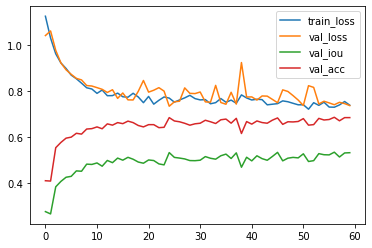

In [8]:
xs = range(EPOCH)
for key, data in records.items():
    plt.plot(xs, data, label=key)
plt.legend()

(128, 128, 3)


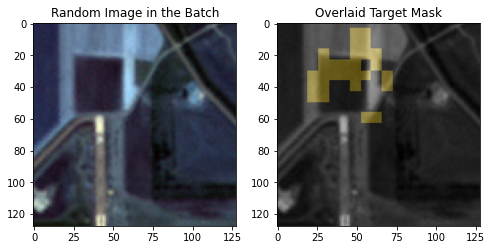

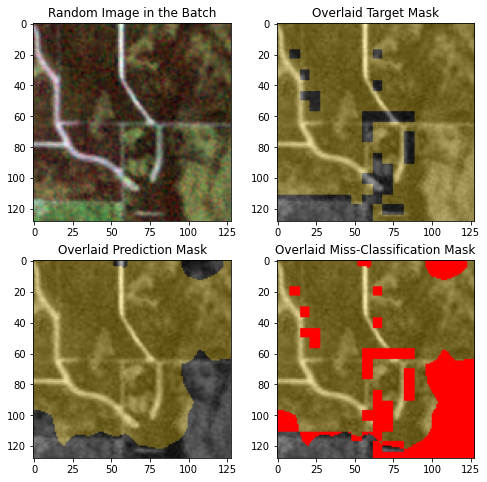

In [14]:
x, y = next(iter(train_loader))
y_pred = fcn(x.to(device))["out"].argmax(axis=1)
visualize_sample(x, y)
visualize_pred(x, y_pred, y)